In [1]:
import sys

!{sys.executable} -m pip install wordcloud Pillow nltk lxml

Defaulting to user installation because normal site-packages is not writeable


In [66]:
import pandas as pd
import numpy as np
import re
import os
from collections import Counter
import glob
import zipfile
import numpy
import re
import nltk
from nltk.tokenize import RegexpTokenizer

HOME_DIR = "/home_remote"
HOME = "/home/thi.tra.my.nguyen"

In [3]:
def datacollection(wpattern="./*.zip"):
    df = pd.DataFrame()
    for g in glob.glob(wpattern):
        zf = zipfile.ZipFile(g)
        dfs = [pd.read_xml(zf.open(f)) for f in zf.namelist()[1:]]
        df = pd.concat(dfs, ignore_index = True)

    return df

test = datacollection(os.path.join(HOME_DIR, "eRisk2018training/2017_test/*.zip"))

In [4]:
def file_concat(path):
    train_neg = pd.DataFrame()
    for i in os.listdir(path):
        #print(i)
        allFiles = glob.glob(path+"/" + i+ "/*.xml")
        dt = []
        for x in allFiles:
            try:
                df = pd.read_xml(x)
                dt.append(df)
                #print(dt)
                train_neg = pd.concat(dt)
            except:
                print("This file error " + x)
    return train_neg

In [5]:
train_neg = file_concat(os.path.join(HOME_DIR, "eRisk2018training/2017_train/negative_examples_anonymous_chunks"))
train_pos = file_concat(os.path.join(HOME_DIR, "eRisk2018training/2017_train/positive_examples_anonymous_chunks"))

This file error /home_remote/eRisk2018training/2017_train/negative_examples_anonymous_chunks/chunk 7/train_subject7619_7-DESKTOP-V0MFQ76.xml
This file error /home_remote/eRisk2018training/2017_train/negative_examples_anonymous_chunks/chunk 1/train_subject7488_1-DESKTOP-V0MFQ76.xml


In [6]:
train_neg

,ID,TITLE,DATE,INFO,TEXT
0,train_subject2466,None,None,None,None
1,None,NaN,2014-04-01 04:55:21,reddit post,I hear you...I'm graduating in may and college...
2,None,NaN,2014-01-09 04:10:53,reddit post,Thanks!...I think...skatest??
3,None,NaN,2014-01-08 02:44:22,reddit post,August 26th 2014 - EA (Engineering Aid)
4,None,Does A school start with the basics?,2014-01-08 02:40:46,reddit post,I was sworn into the Navy and am on track to b...
...,...,...,...,...,...
12,None,NaN,2013-07-31 21:20:51,reddit post,I was considering organizing a Reddit meet-up ...
13,None,NaN,2013-07-31 16:48:57,reddit post,All I used was a pair of scissors and my hands...
14,None,[Self] WIP cape for my Tetsuo costume for this...,2013-07-31 01:00:31,reddit post,NaN
15,None,[WIP] The cape for my Tetsuo costume for Drago...,2013-07-30 21:28:51,reddit post,NaN


### EDA

#### Word Cloud

In [7]:
train_pos = train_pos.dropna(subset=['TEXT'])
train_neg = train_neg.dropna(subset=['TEXT'])

In [8]:
#reference: https://docs.python.org/3/library/re.html and 
#https://thinkinfi.com/fasttext-word-embeddings-python-implementation/
def process_text(document):

        # Remove extra white space from text
        document = re.sub(r'\s+', ' ', document, flags=re.I)
         
        # Remove all the special characters from text
        document = re.sub(r'\W', ' ', str(document))
 
        # Remove all single characters from text
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
 
        # Converting to lowercase
        document = document.lower()
 
        return document

#reference: https://www.nltk.org/api/nltk.tokenize.regexp.html
cleaned_train = [process_text(sentence) for sentence in train_neg['TEXT'] if sentence.strip() !='']
tokenizer_train = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')
train_token_neg= [tokenizer_train.tokenize(sent) for sent in cleaned_train]

cleaned_test = [process_text(sentence) for sentence in train_pos['TEXT'] if sentence.strip() !='']
train_token_pos = [tokenizer_train.tokenize(sent) for sent in cleaned_test]


In [13]:
#flatten the list train_token_neg and train_token_pos
train_token_neg = [item for sublist in train_token_neg for item in sublist]
train_token_pos = [item for sublist in train_token_pos for item in sublist]

In [14]:
#remove stopwords in train_token_neg and train_token_pos
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
train_token_neg = [w for w in train_token_neg if not w in stop_words]
train_token_pos = [w for w in train_token_pos if not w in stop_words]

#remove duplicates
train_token_neg = list(dict.fromkeys(train_token_neg))
train_token_pos = list(dict.fromkeys(train_token_pos))

#remove words with length less than 3
train_token_neg = [w for w in train_token_neg if len(w) >= 3]
train_token_pos = [w for w in train_token_pos if len(w) >=3]

#remove words are popular with frequency more than 10 times in both positive and negative
freq_neg = pd.Series(' '.join(train_neg['TEXT']).split()).value_counts()[:50]
freq_pos = pd.Series(' '.join(train_pos['TEXT']).split()).value_counts()[:50]
freq_neg = list(freq_neg.index)
freq_pos = list(freq_pos.index)
train_token_neg = [w for w in train_token_neg if w not in freq_neg and freq_pos]
train_token_pos = [w for w in train_token_pos if w not in freq_pos and freq_neg]


In [35]:
train_token_neg = [w for w in train_token_neg if w not in ['college', 'hear','seem','cup']]
train_token_pos = [w for w in train_token_pos if w not in ['call','economic','american','one','law']]

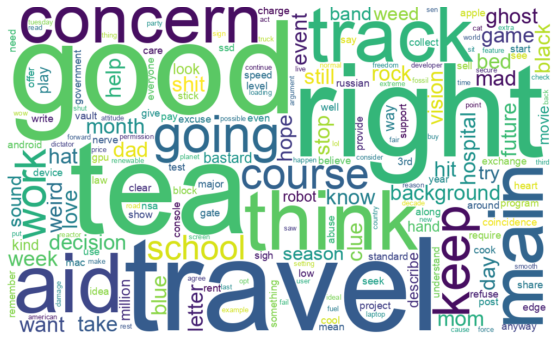

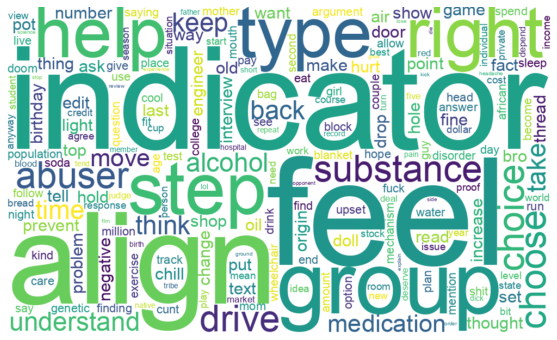

In [39]:
#wordcloud for train_token_final and test_token_final
import matplotlib.pyplot as plt
from wordcloud import WordCloud

text1 = " ".join(train_token_neg)
text2 = " ".join(train_token_pos)

# Create and generate a word cloud image:
font_path = os.path.join(HOME_DIR, 'fonts/Arial.ttf')
wordcloud_neg= WordCloud(width=1000, height=600, background_color='white', font_path=font_path).generate(text1)
wordcloud_pos= WordCloud(width=1000, height=600, background_color='white', font_path=font_path).generate(text2)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.figure(figsize=(10,6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.show()
#save picture as pdf
wordcloud_neg.to_file(os.path.join(HOME,  'wordcloud_neg.pdf'))
wordcloud_pos.to_file(os.path.join(HOME, 'wordcloud_pos.pdf'))
